In [ ]:
!pip install datasets -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
!pip install transformers -qq

In [ ]:
!pip install evaluate -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.5 MB/s eta 0:00:00


In [ ]:
from typing import List, Tuple

In [ ]:
from datasets import load_dataset, Dataset
import evaluate
import numpy as np
from sklearn.metrics import classification_report
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
from transformers import pipeline

# Языковые модели трансформеры

[Attention Is All You Need](https://arxiv.org/abs/1706.03762) – архетектура трансформера  
[BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805) – про BERT  
[Модели внимания и трансформеры](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B0%D1%88%D0%B8%D0%BD%D0%BD%D0%BE%D0%B5_%D0%BE%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%9A.%D0%92.%D0%92%D0%BE%D1%80%D0%BE%D0%BD%D1%86%D0%BE%D0%B2%29#.D0.9C.D0.BE.D0.B4.D0.B5.D0.BB.D0.B8_.D0.B2.D0.BD.D0.B8.D0.BC.D0.B0.D0.BD.D0.B8.D1.8F_.D0.B8_.D1.82.D1.80.D0.B0.D0.BD.D1.81.D1.84.D0.BE.D1.80.D0.BC.D0.B5.D1.80.D1.8B) – лекция Воронцова про трансформеры




**Запись лекции про трансформеры**  
https://www.youtube.com/watch?v=KhMweP00S44

## Механизм внимания

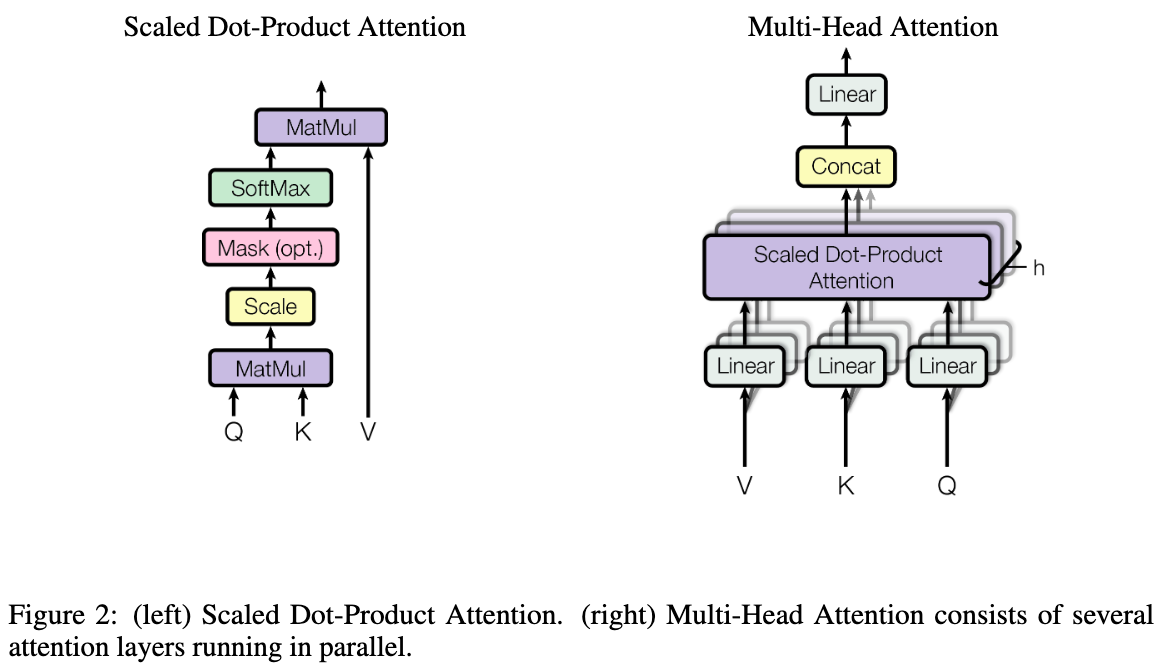

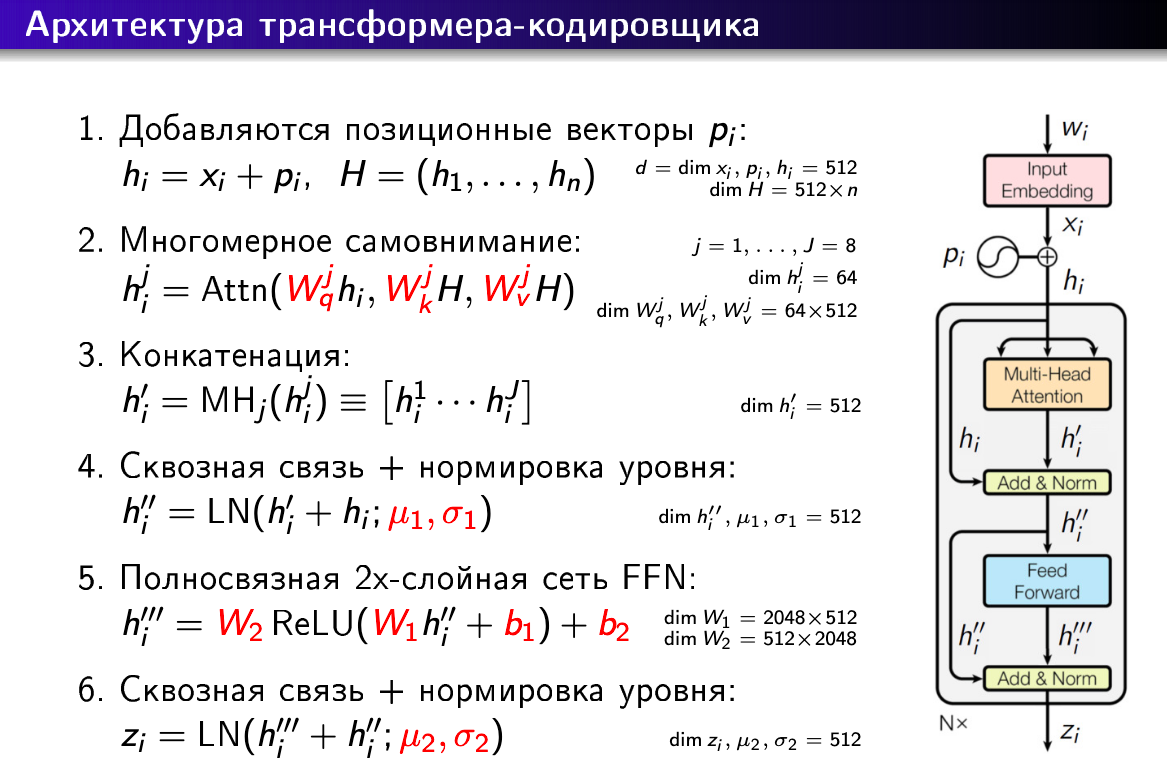

## Предварительное обучение BERT

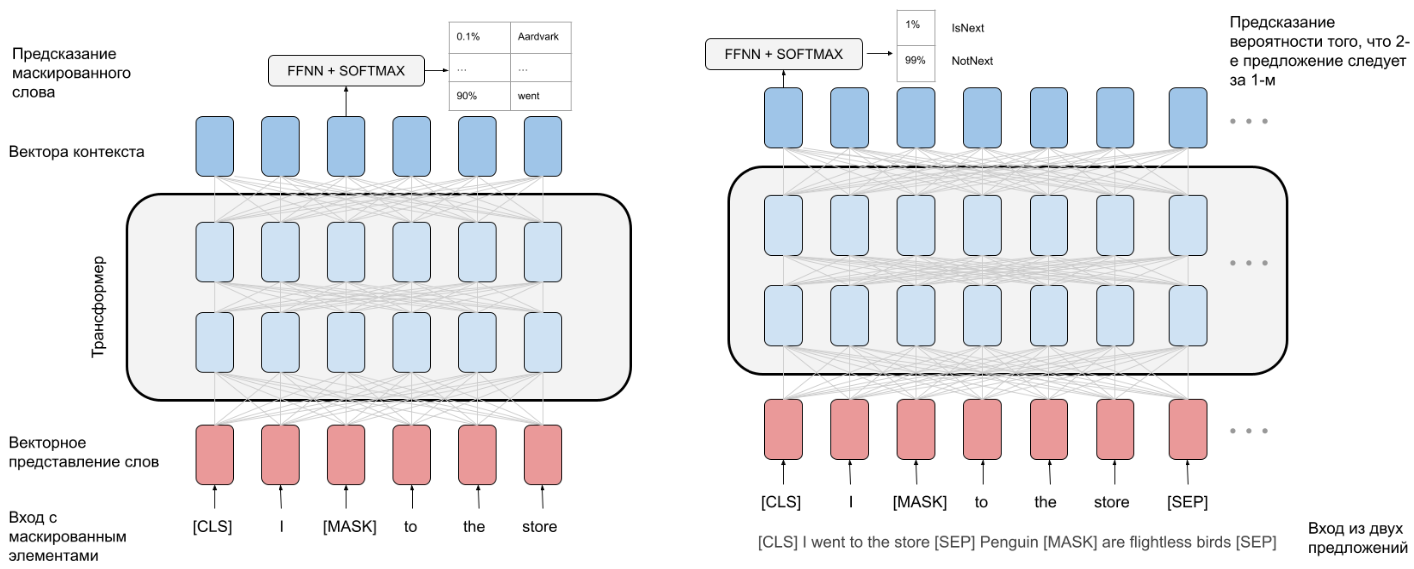

## BERT "понимает" грамматику и синтаксис языка

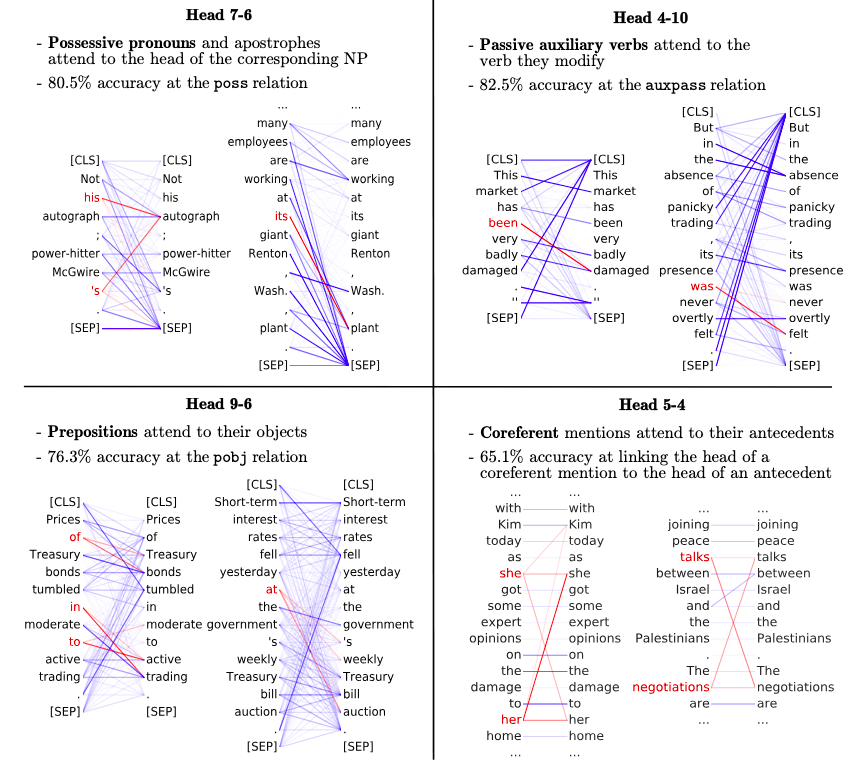

[What does BERT look at? An Analysis of BERT’s Attention / Clark et al. // 2019](https://aclanthology.org/W19-4828/)

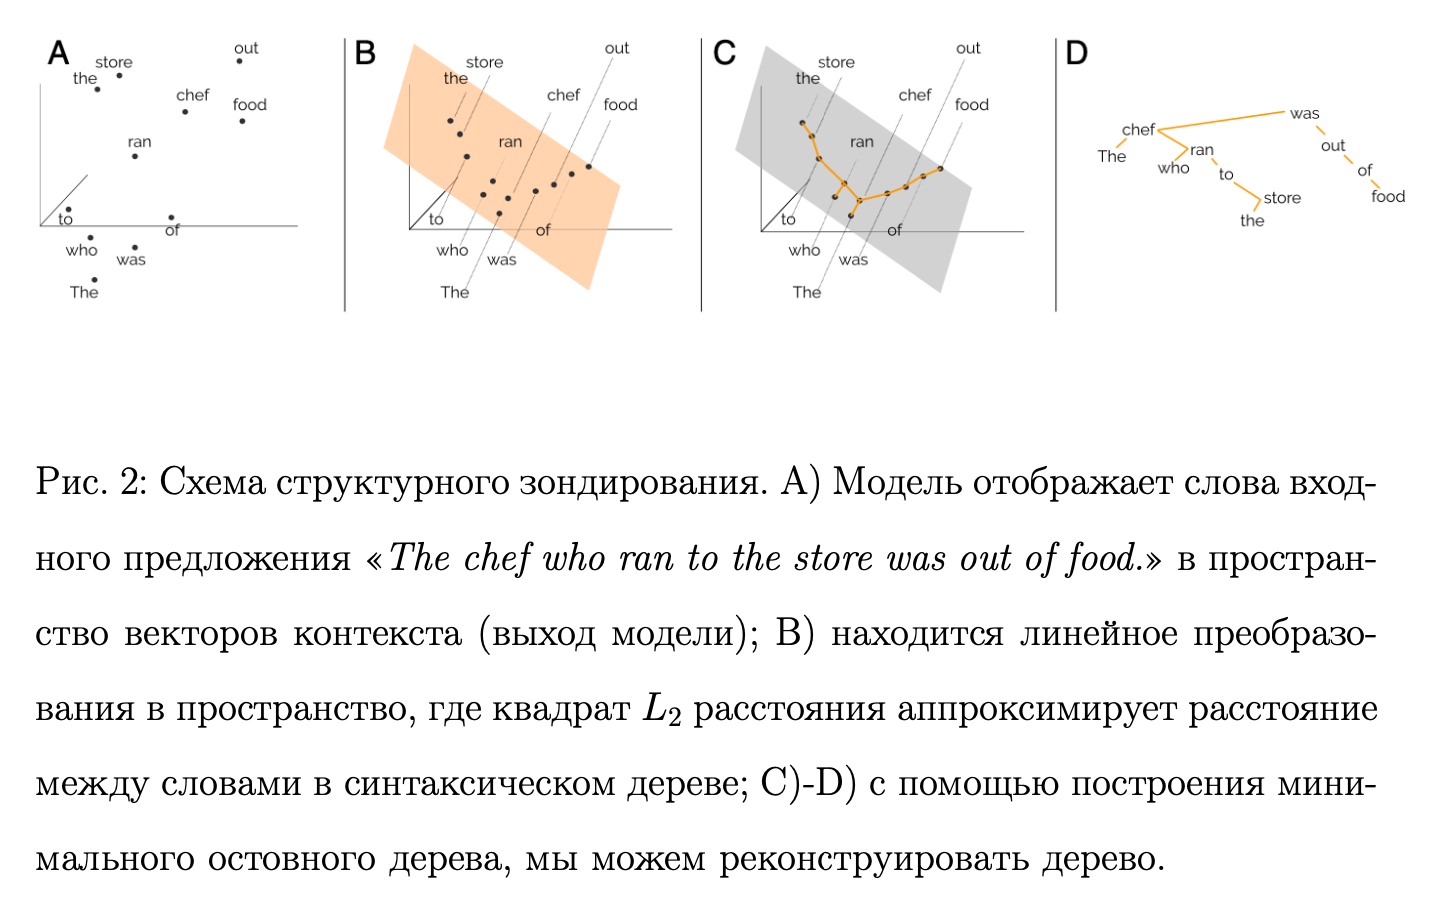

[A Structural Probe for Finding Syntax in Word Representations / Hewitt & Manning // 2019](https://aclanthology.org/N19-1419/)  
[Visualizing and Measuring the Geometry of BERT / Coenen et al. // 2019](https://arxiv.org/abs/1906.02715)

# Pipeline дообучения модели

In [ ]:
SEED = 42

## Загрузим токенайзер

In [ ]:
#MODEL_NAME = 'DeepPavlov/rubert-base-cased'
MODEL_NAME = 'sberbank-ai/sbert_large_nlu_ru'er
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
seq = 'Привет о дивный новый мир!'
print(tokenizer.encode(seq))
print(tokenizer.convert_ids_to_tokens(tokenizer.encode(seq)))

[101, 6571, 104, 118524, 667, 378, 12695, 391, 378, 2386, 177, 102]
['[CLS]', 'привет', 'о', 'див', '##ны', '##и', 'нов', '##ы', '##и', 'мир', '!', '[SEP]']


## Загрузим данные

In [ ]:
DATASET_NAME = 'Davlan/sib200'
DATASET_LANGUAGE = 'rus_Cyrl'
train_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='train')
validation_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='validation')
test_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='test')

README.md:   0%|          | 0.00/47.9k [00:00<?, ?B/s]

data/rus_Cyrl/train.tsv:   0%|          | 0.00/195k [00:00<?, ?B/s]

data/rus_Cyrl/dev.tsv:   0%|          | 0.00/25.3k [00:00<?, ?B/s]

data/rus_Cyrl/test.tsv:   0%|          | 0.00/57.4k [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [ ]:
print(train_set)

Dataset({
    features: ['index_id', 'category', 'text'],
    num_rows: 701
})


## Токенизируем тексты

In [ ]:
MINIBATCH_SIZE = 64
tokenized_train_set = train_set.map(
    lambda it: tokenizer(it['text'], truncation=True),
    batched=True, batch_size=MINIBATCH_SIZE
)
tokenized_validation_set = validation_set.map(
    lambda it: tokenizer(it['text'], truncation=True),
    batched=True, batch_size=MINIBATCH_SIZE
)

Map:   0%|          | 0/701 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/99 [00:00<?, ? examples/s]

In [ ]:
print(tokenized_train_set)

Dataset({
    features: ['index_id', 'category', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 701
})


## Загрузим метрику для оценки качества модели на задаче классификации

In [ ]:
cls_metric = evaluate.load('f1')

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return cls_metric.compute(predictions=predictions, references=labels, average='macro')

## Создадим вспомогательный объект для трансформации данных в тензор

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Конвертируем категории в целевые метки

In [ ]:
list_of_categories = sorted(list(
    set(train_set['category']) | set(validation_set['category']) | set(test_set['category'])
))
indices_of_categories = list(range(len(list_of_categories)))
n_categories = len(list_of_categories)
print(f'Categories for classification are: {list_of_categories}')
id2label = dict(zip(indices_of_categories, list_of_categories))
label2id = dict(zip(list_of_categories, indices_of_categories))

Categories for classification are: ['entertainment', 'geography', 'health', 'politics', 'science/technology', 'sports', 'travel']


In [ ]:
labeled_train_set = tokenized_train_set.add_column(
    'label',
    [label2id[val] for val in tokenized_train_set['category']]
)
labeled_validation_set = tokenized_validation_set.add_column(
    'label',
    [label2id[val] for val in tokenized_validation_set['category']]
)

In [ ]:
print(labeled_train_set)

Dataset({
    features: ['index_id', 'category', 'text', 'input_ids', 'token_type_ids', 'attention_mask', 'label'],
    num_rows: 701
})


## Загружаем наш BERT
И определем его на видеокарту

In [ ]:
classifier = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=n_categories, id2label=id2label, label2id=label2id
).cuda()
for param in classifier.parameters(): param.data = param.data.contiguous()

config.json:   0%|          | 0.00/863 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/sbert_large_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Этап обучения

In [ ]:
training_args = TrainingArguments(
    output_dir='rubert_sib200',
    learning_rate=2e-5,
    per_device_train_batch_size=MINIBATCH_SIZE,
    per_device_eval_batch_size=MINIBATCH_SIZE,
    num_train_epochs=10,
    weight_decay=1e-3,
    eval_strategy='epoch',
    save_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    logging_steps = 5,
    #save_strategy="no",
    #load_best_model_at_end=True,
    #metric_for_best_model="loss",
    #greater_is_better=False,
    # "warmup_ratio": 1/10,
    # "lr_scheduler_type": "cosine",
    # fp16=(device.type != 'cpu'),
    data_seed=SEED,
)

In [ ]:
trainer = Trainer(
    model=classifier,
    args=training_args,
    train_dataset=labeled_train_set,
    eval_dataset=labeled_validation_set,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

f6a28b8af9cb71be08525cee108602a430717f68

In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,F1
1,No log,1.409573,0.419188
2,No log,1.042755,0.615970
3,No log,0.716679,0.842249
4,No log,0.553048,0.877030
5,0.986900,0.473826,0.863111
6,0.986900,0.422932,0.861253
7,0.986900,0.444603,0.866650
8,0.986900,0.425096,0.876236
9,0.986900,0.447155,0.866650
10,0.116500,0.441928,0.866650


TrainOutput(global_step=110, training_loss=0.506043267250061, metrics={'train_runtime': 954.9231, 'train_samples_per_second': 7.341, 'train_steps_per_second': 0.115, 'total_flos': 824694920989938.0, 'train_loss': 0.506043267250061, 'epoch': 10.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.4229317903518677,
 'eval_f1': 0.8612526262882205,
 'eval_runtime': 1.1583,
 'eval_samples_per_second': 85.468,
 'eval_steps_per_second': 1.727,
 'epoch': 10.0}

In [ ]:
classifiсation_pipeline = pipeline('text-classification', model=classifier, tokenizer=tokenizer, device=0)

In [ ]:
y_pred = list(map(lambda x: x['label'], classifiсation_pipeline(test_set['text'])))
y_true = test_set['category']
print(classification_report(y_true=y_true, y_pred=y_pred))

                    precision    recall  f1-score   support

     entertainment       0.86      0.67      0.75         9
         geography       0.78      0.88      0.82         8
            health       1.00      0.73      0.84        11
          politics       1.00      0.93      0.96        14
science/technology       0.89      1.00      0.94        25
            sports       0.91      0.83      0.87        12
            travel       0.78      0.90      0.84        20

          accuracy                           0.88        99
         macro avg       0.89      0.85      0.86        99
      weighted avg       0.89      0.88      0.88        99



In [ ]:
y_pred[0]

'sports'

## Sber
         macro avg       0.89      0.85      !0.86        99
      weighted avg       0.89      0.88      !0.88        99

## DeepPavlov
         macro avg       0.85      0.80      !0.82        99
      weighted avg       0.84      0.83      !0.83        99